In [ ]:
!pip install torchmetrics
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
!git clone https://github.com/jalpv1//wiki-art-selected-resized-downsampled
!rm -rf .//wiki-art-selected-resized-downsampled/.git
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import time
import os
import copy
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
import cv2
import numpy as np
import imageio as io
from PIL import Image
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
!python --version
!nvcc --version
!pip install nvcc4jupyter
%load_ext nvcc4jupyter
class_names = ['Abstract_Expressionism','Baroque','Cubism', 'Fauvism', 'Impressionism','Minimalism','Naive_Art_Primitivism','Pointillism','Rococo','Ukiyo_e']
device = 'cuda'
!pip install torchsampler
class ArtStyleDataset(Dataset):
  def __init__(self, root_dir, transform = None, transform_tensor = None):
     self.imgs = ImageFolder(root_dir)
     self.root_dir = root_dir
     self.transform = transform
     self.transform_tensor = transform_tensor


  def __len__(self):
        return len(self.imgs)

  def __getitem__(self, idx):
        sample, label = self.imgs[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, label

transform = transforms.Compose([
    transforms.Resize((229, 229)),
    transforms.ToTensor(),
])
#load data
data = ArtStyleDataset('wiki-art-selected-resized-downsampled', transform)

from torch.utils.data import Dataset, DataLoader, random_split
train_size = int(0.8 * len(data))
test_size = int(0.2 * len(data))
#val_size = len(data) - train_size - test_size
train_dataset, test_dataset = random_split(data, [train_size, test_size])

train_loader = DataLoader(train_dataset, shuffle=True,num_workers=4)
test_loader = DataLoader(test_dataset, shuffle=False, num_workers=4)
#val_loader = DataLoader(val_dataset, shuffle=False, num_workers=4)

from torch.utils.data import WeightedRandomSampler

def extract_labels():
  features = []
  labels_ = []
  map_img_feature = {}
  for inputs, labels in train_loader:
      labels_.append(labels.numpy())
  return labels_
y = extract_labels()
y = np.concatenate(y)
unique, counts = np.unique(y, return_counts=True)


#Up sampling
class_weights = [1.0/c for c in counts]
sample_weights = [class_weights[i] for i in y]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

train_loader = DataLoader(train_dataset,sampler=sampler, batch_size = 32)
dataset_sizes= {"train" : len(train_loader), "test" : len(test_loader)}



Cloning into 'wiki-art-selected-resized-downsampled'...
remote: Enumerating objects: 18446, done.
remote: Total 18446 (delta 0), reused 0 (delta 0), pack-reused 18446 (from 1)
Receiving objects: 100% (18446/18446), 843.56 MiB | 16.54 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (18505/18505), done.
Python 3.11.11
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
The nvcc4jupyter extension is already loaded. To reload it, use:
  %reload_ext nvcc4jupyter


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
import torchmetrics
import pytorch_lightning as pl

num_classes = 10

In [ ]:
f1_densenet121 = []
accuracy_densenet121 = []
recall_densenet121 = []
precision_densenet121 = []

class DenseNet121(pl.LightningModule):
    def __init__(self, num_classes):
        super(DenseNet121, self).__init__()
        self.model = models.densenet121(pretrained=True)
        self.validation_step_outputs = []
        self.train_step_outputs = []

        for param in self.model.parameters():
            param.requires_grad = False



        self.model.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )

        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes, average='weighted')
        self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes, average='weighted')
        self.f1_val = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average='weighted')
        self.f1_train = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average='weighted')
        self.precision_val = torchmetrics.Precision(task="multiclass", num_classes=num_classes, average='weighted')
        self.recall_val = torchmetrics.Recall(task="multiclass", num_classes=num_classes, average='weighted')


    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = nn.CrossEntropyLoss()(logits, y)
        preds = torch.argmax(logits, dim=1)

        self.accuracy.update(preds, y)
        self.f1_train.update(preds, y)

        self.train_step_outputs.append(loss)


        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        val_loss = nn.CrossEntropyLoss()(logits, y)

        preds = torch.argmax(logits, dim=1)

        self.val_accuracy(preds, y)
        self.f1_val(preds, y)
        self.precision_val(preds, y)
        self.recall_val(preds, y)


        self.val_accuracy.update(preds, y)
        self.f1_val.update(preds, y)
        self.precision_val.update(preds, y)
        self.recall_val.update(preds, y)



        self.validation_step_outputs.append(val_loss)



    def on_train_epoch_end(self):
        train_acc = self.accuracy.compute()
        epoch_f1_train = self.f1_train.compute()
        print(f"Epoch {self.current_epoch}: Train Accuracy: {train_acc:.4f} F1: {epoch_f1_train:.4f}")
        self.accuracy.reset()
        self.f1_train.reset()

    def on_validation_epoch_end(self):
        epoch_val_acc = self.val_accuracy.compute()
        avg_val_loss = torch.stack(self.validation_step_outputs).mean()
        epoch_f1_val = self.f1_val.compute()
        epoch_precision_val = self.precision_val.compute()
        epoch_recall_val = self.recall_val.compute()

        print(f"Epoch {self.current_epoch}: Validation Accuracy: {epoch_val_acc:.4f} F1: {epoch_f1_val:.4f}  Recall: {epoch_recall_val:.4f}  Precision: {epoch_precision_val:.4f}")
        self.log("validation_epoch_accuracy", epoch_val_acc)
        self.log("validation_epoch_loss", avg_val_loss)
        self.log("f1_val", epoch_f1_val)

        f1_densenet121.append(epoch_f1_val.cpu().numpy())
        accuracy_densenet121.append(epoch_val_acc.cpu().numpy())
        recall_densenet121.append(epoch_recall_val.cpu().numpy())
        precision_densenet121.append(epoch_precision_val.cpu().numpy())

        self.val_accuracy.reset()
        self.f1_val.reset()
        self.precision_val.reset()
        self.recall_val.reset()


        self.validation_step_outputs.clear()




    def configure_optimizers(self):
        # Only optimize the final layer
        optimizer = torch.optim.Adam(self.model.classifier.parameters(), lr=0.0001)
        return optimizer


In [ ]:
checkpoint_callback18 = ModelCheckpoint(

     monitor='f1_val',
       mode='max',
     dirpath='my/path2/',
     filename='dense-{epoch:02d}-{f1_val:.2f}'
)

trainer18 = pl.Trainer(
    max_epochs=25,
   accelerator="cuda",
    callbacks =checkpoint_callback18
)

modeDenseNet121 = DenseNet121(num_classes=num_classes)


trainer18.fit(modeDenseNet121, train_loader, test_loader, ckpt_path=None)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: Validation Accuracy: 0.0000 F1: 0.0000  Recall: 0.0000  Precision: 0.0000


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: Validation Accuracy: 0.6239 F1: 0.5996  Recall: 0.6239  Precision: 0.6246
Epoch 0: Train Accuracy: 0.4352 F1: 0.4136


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: Validation Accuracy: 0.6587 F1: 0.6444  Recall: 0.6587  Precision: 0.6718
Epoch 1: Train Accuracy: 0.5955 F1: 0.5808


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: Validation Accuracy: 0.6828 F1: 0.6740  Recall: 0.6828  Precision: 0.6852
Epoch 2: Train Accuracy: 0.6404 F1: 0.6329


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: Validation Accuracy: 0.6976 F1: 0.6942  Recall: 0.6976  Precision: 0.7024
Epoch 3: Train Accuracy: 0.6675 F1: 0.6619


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: Validation Accuracy: 0.7158 F1: 0.7121  Recall: 0.7158  Precision: 0.7173
Epoch 4: Train Accuracy: 0.6757 F1: 0.6722


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: Validation Accuracy: 0.7174 F1: 0.7117  Recall: 0.7174  Precision: 0.7199
Epoch 5: Train Accuracy: 0.6996 F1: 0.6970


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: Validation Accuracy: 0.7171 F1: 0.7128  Recall: 0.7171  Precision: 0.7202
Epoch 6: Train Accuracy: 0.7056 F1: 0.7028


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: Validation Accuracy: 0.7301 F1: 0.7269  Recall: 0.7301  Precision: 0.7279
Epoch 7: Train Accuracy: 0.7147 F1: 0.7120


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: Validation Accuracy: 0.7344 F1: 0.7309  Recall: 0.7344  Precision: 0.7337
Epoch 8: Train Accuracy: 0.7257 F1: 0.7236


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: Validation Accuracy: 0.7298 F1: 0.7281  Recall: 0.7298  Precision: 0.7316
Epoch 9: Train Accuracy: 0.7326 F1: 0.7306


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: Validation Accuracy: 0.7336 F1: 0.7309  Recall: 0.7336  Precision: 0.7334
Epoch 10: Train Accuracy: 0.7395 F1: 0.7376


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: Validation Accuracy: 0.7433 F1: 0.7403  Recall: 0.7433  Precision: 0.7421
Epoch 11: Train Accuracy: 0.7388 F1: 0.7368


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: Validation Accuracy: 0.7341 F1: 0.7314  Recall: 0.7341  Precision: 0.7342
Epoch 12: Train Accuracy: 0.7415 F1: 0.7397


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13: Validation Accuracy: 0.7428 F1: 0.7398  Recall: 0.7428  Precision: 0.7426
Epoch 13: Train Accuracy: 0.7488 F1: 0.7472


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: Validation Accuracy: 0.7447 F1: 0.7430  Recall: 0.7447  Precision: 0.7448
Epoch 14: Train Accuracy: 0.7505 F1: 0.7491


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15: Validation Accuracy: 0.7352 F1: 0.7328  Recall: 0.7352  Precision: 0.7361
Epoch 15: Train Accuracy: 0.7521 F1: 0.7505


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16: Validation Accuracy: 0.7417 F1: 0.7393  Recall: 0.7417  Precision: 0.7415
Epoch 16: Train Accuracy: 0.7601 F1: 0.7588


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17: Validation Accuracy: 0.7455 F1: 0.7447  Recall: 0.7455  Precision: 0.7455
Epoch 17: Train Accuracy: 0.7606 F1: 0.7593


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18: Validation Accuracy: 0.7528 F1: 0.7505  Recall: 0.7528  Precision: 0.7520
Epoch 18: Train Accuracy: 0.7704 F1: 0.7692


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19: Validation Accuracy: 0.7544 F1: 0.7535  Recall: 0.7544  Precision: 0.7545
Epoch 19: Train Accuracy: 0.7749 F1: 0.7737


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20: Validation Accuracy: 0.7511 F1: 0.7501  Recall: 0.7511  Precision: 0.7510
Epoch 20: Train Accuracy: 0.7772 F1: 0.7763


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21: Validation Accuracy: 0.7482 F1: 0.7450  Recall: 0.7482  Precision: 0.7479
Epoch 21: Train Accuracy: 0.7726 F1: 0.7715


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22: Validation Accuracy: 0.7441 F1: 0.7426  Recall: 0.7441  Precision: 0.7492
Epoch 22: Train Accuracy: 0.7791 F1: 0.7781


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23: Validation Accuracy: 0.7476 F1: 0.7461  Recall: 0.7476  Precision: 0.7466
Epoch 23: Train Accuracy: 0.7835 F1: 0.7825


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: Validation Accuracy: 0.7530 F1: 0.7511  Recall: 0.7530  Precision: 0.7532
Epoch 24: Train Accuracy: 0.7792 F1: 0.7782


In [ ]:
dense-epoch=19-f1_val=0.75.ckpt

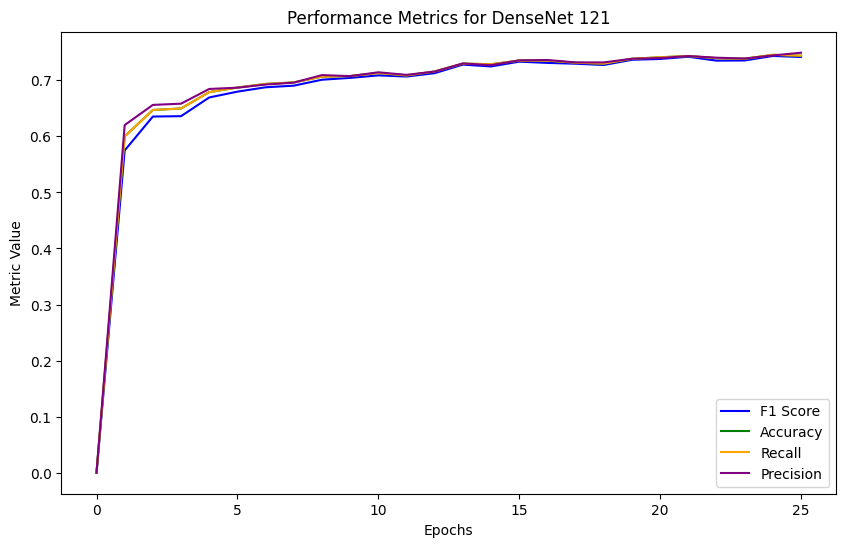

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
x_values = range(len(f1_densenet121))

plt.figure(figsize=(10, 6))

sns.lineplot(x=x_values, y= [float(item) for item in f1_densenet121], label="F1 Score", color="blue")
sns.lineplot(x=x_values, y=[float(item) for item in accuracy_densenet121], label="Accuracy", color="green")
sns.lineplot(x=x_values, y= [float(item) for item in recall_densenet121], label="Recall", color="orange")
sns.lineplot(x=x_values, y=[float(item) for item in precision_densenet121], label="Precision", color="purple")

plt.title("Performance Metrics for DenseNet 121")
plt.xlabel("Epochs")
plt.ylabel("Metric Value")

plt.legend()
plt.show()

In [ ]:
def evaluate_model(predicted, true):
  from sklearn.metrics import classification_report
  import pandas as pd
  from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
  import matplotlib.pyplot as plt
  report_dict = classification_report(predicted, true, target_names=class_names, output_dict=True)
  metrics_df2 = pd.DataFrame(report_dict).transpose()
  print(metrics_df2)

  disp = ConfusionMatrixDisplay(confusion_matrix(true, predicted, normalize = 'true' )*100, display_labels=class_names)

  fig, ax = plt.subplots(figsize=(8, 6))
  disp.plot(cmap="cividis", ax=ax)
  for _, spine in ax.spines.items():
      spine.set_visible(False)
  plt.xticks(rotation=90, ha="right")
  plt.yticks(rotation=0)
  plt.grid(False)
  plt.title("Confusion Matrix")
    #plt.colorbar(ax.collections[0], ax=ax)
  disp = ConfusionMatrixDisplay(confusion_matrix(true, predicted), display_labels=class_names)

  fig, ax = plt.subplots(figsize=(8, 6))
  disp.plot(cmap="cividis", ax=ax)
  for _, spine in ax.spines.items():
        spine.set_visible(False)

  plt.xticks(rotation=90, ha="right")
  plt.yticks(rotation=0)
  plt.grid(False)
  plt.title("Not normalized Confusion Matrix")
  plt.show()


def validate_model(model, data_loader):
    pred = []
    true = []
    model.eval()

    start_time = time.time()
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs.float())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            true.extend(labels.cpu().numpy())
            pred.extend(predicted.cpu().numpy())

        accuracy = 100 * correct / total  # Calculate accuracy based on predictions

        print('Finished Testing')
        print(f'Testing accuracy: {accuracy:.1f} %')

    evaluate_model(pred, true)